# Imports

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.providers.basic_provider import BasicSimulator  
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, ADAM
from qiskit.circuit import Parameter, ParameterVector
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator, Aer  # Correct import for AerSimulator
from scipy.signal import argrelextrema
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import EfficientSU2

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit import transpile
from sklearn.model_selection import train_test_split

from typing import List, Callable, Union

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

from qiskit.visualization import circuit_drawer
np.random.seed(42)


# Preprocess data

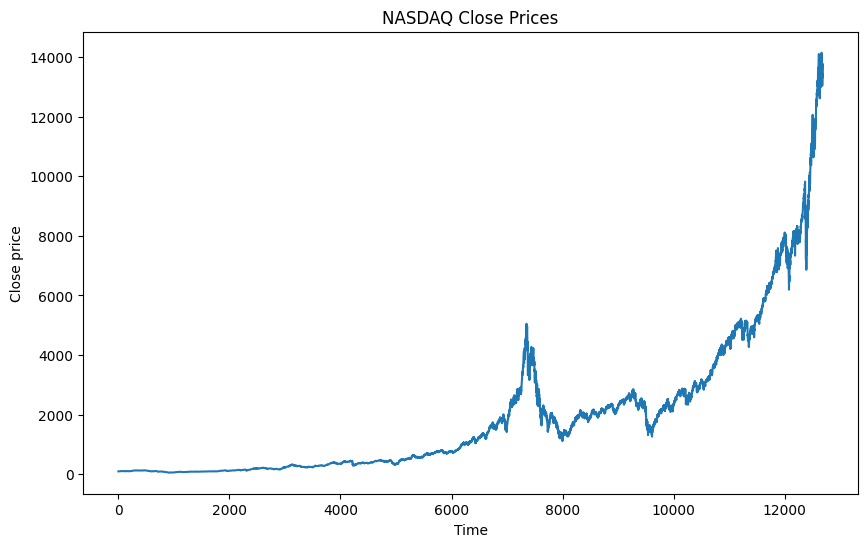

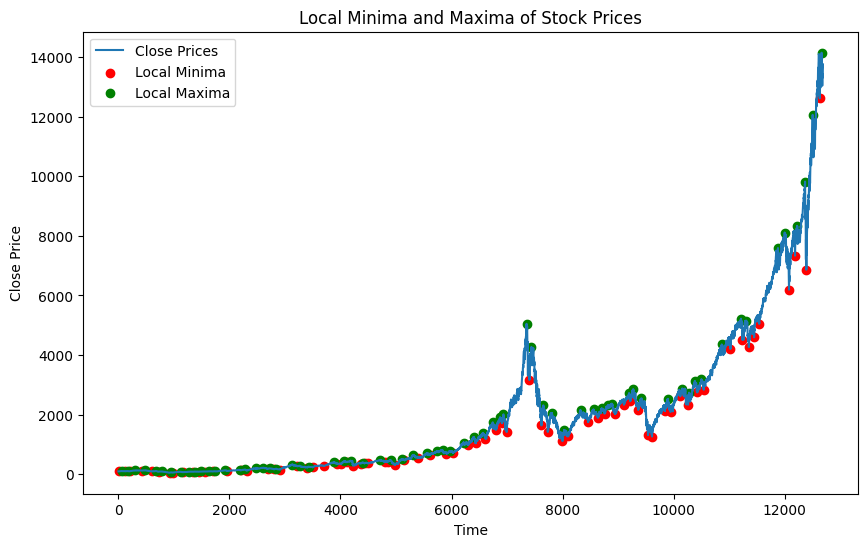

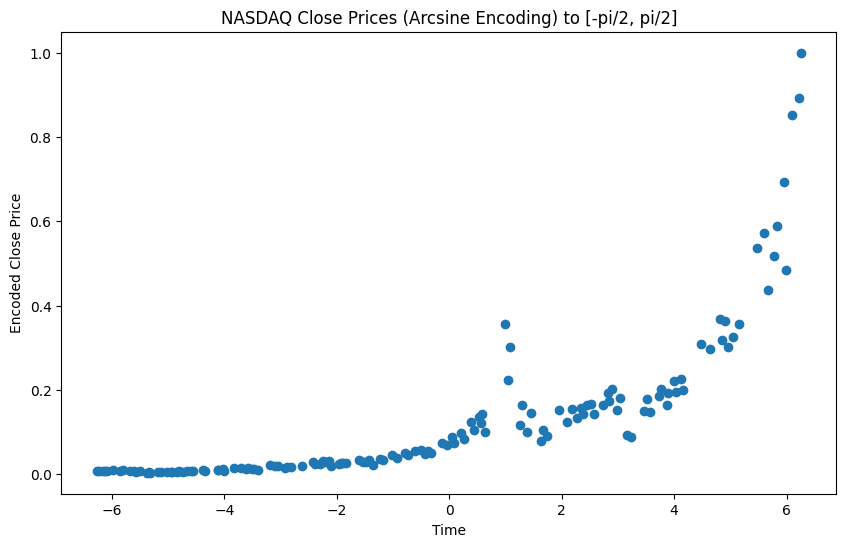

In [73]:
# load dataset
stock_data = pd.read_csv('C:/Users/lucam/OneDrive/Desktop/ZHAW/Semester_5/QI/Project/git/Quantum-Computing-Data-Repetition/src/experiments/serial_data/data/indexData.csv')  
nasdaq_data = stock_data[stock_data['Index'] == 'IXIC']
close_prices = nasdaq_data['Close'].values  
x = np.arange(len(close_prices)) 

plt.figure(figsize=(10, 6))
plt.plot(x, close_prices)
plt.title("NASDAQ Close Prices")
plt.xlabel("Time")
plt.ylabel("Close price")
plt.show()

# Normalize close prices to range [0, 2*pi]
max_close_price = max(close_prices)
y = (close_prices / max_close_price) * 2 * np.pi  # Normalize data to [0, 2*pi]


order = 50
local_minima = argrelextrema(close_prices, np.less, order=order)[0]
local_maxima = argrelextrema(close_prices, np.greater, order=order)[0]
plt.figure(figsize=(10, 6))
plt.plot(close_prices, label="Close Prices")
plt.scatter(local_minima, close_prices[local_minima], marker='o', color='red', label="Local Minima")
plt.scatter(local_maxima, close_prices[local_maxima], marker='o', color='green', label="Local Maxima")
plt.title("Local Minima and Maxima of Stock Prices")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()
num_extrema = len(local_minima) + len(local_maxima)

x_points = np.concatenate((local_minima, local_maxima))
y_points = close_prices[x_points]

# Normalize the x_points to [-2*pi, 2*pi] and y to [-1, 1]
x_points = (x_points / len(close_prices)) * 4 * np.pi - 2 * np.pi
y_points = (y_points / max_close_price)

plt.figure(figsize=(10, 6))
plt.plot(x_points, y_points, 'o')
plt.title("NASDAQ Close Prices (Arcsine Encoding) to [-pi/2, pi/2]")
plt.xlabel("Time")
plt.ylabel("Encoded Close Price")
plt.show()


# Serial Model

ParameterView([Parameter(W[0]), Parameter(W[10]), Parameter(W[11]), Parameter(W[1]), Parameter(W[2]), Parameter(W[3]), Parameter(W[4]), Parameter(W[5]), Parameter(W[6]), Parameter(W[7]), Parameter(W[8]), Parameter(W[9]), Parameter(X)])


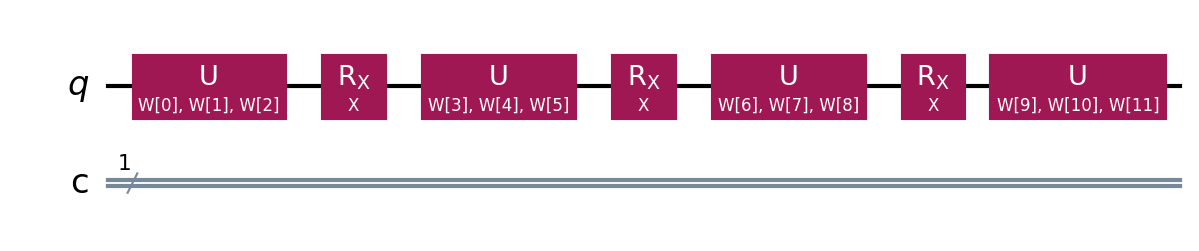

In [ ]:
def serial_fourier_model(layers):
    
    ansatz = QuantumCircuit(1, 1, name="ansatz")
    param_x = Parameter('X')
    pno = 0 # Variational parameter counter

    # Data encoding block
    def S():
        ansatz.rx(param_x, 0)

    # Trainable variational block
    def W(layer, label):
        nonlocal pno
        param_w_0 = Parameter(label+'['+str(pno)+']')
        param_w_1 = Parameter(label+'['+str(pno+1)+']')
        param_w_2 = Parameter(label+'['+str(pno+2)+']')
        ansatz.u(param_w_0, param_w_1, param_w_2, 0)
        pno += 3

    # Create layers of W, S blocks
    for l in range(layers):
        W(l, 'W')
        S()

    # Add the final block
    W(layers, 'W')


    # Measurement step (measure qubit 0 into classical bit 0)
    ansatz.measure(0, 0)
    return ansatz    

# Show a sample serial model with the specified number of layers
m = serial_fourier_model(3)

# Show all parameters, the last is X
print(m.parameters)

# Show the circuit
m.draw(output='mpl', scale=1.5, fold=True)

Counts for x=-3.141592653589793: {'1': 349, '0': 675}
Counts for x=-3.050531996964002: {'0': 738, '1': 286}
Counts for x=-2.9594713403382107: {'1': 259, '0': 765}
Counts for x=-2.86841068371242: {'1': 241, '0': 783}
Counts for x=-2.7773500270866287: {'0': 843, '1': 181}
Counts for x=-2.6862893704608375: {'0': 850, '1': 174}
Counts for x=-2.5952287138350467: {'1': 173, '0': 851}
Counts for x=-2.5041680572092555: {'0': 889, '1': 135}
Counts for x=-2.4131074005834643: {'1': 130, '0': 894}
Counts for x=-2.322046743957673: {'0': 913, '1': 111}
Counts for x=-2.230986087331882: {'0': 938, '1': 86}
Counts for x=-2.139925430706091: {'0': 955, '1': 69}
Counts for x=-2.0488647740803: {'0': 971, '1': 53}
Counts for x=-1.9578041174545087: {'0': 982, '1': 42}
Counts for x=-1.8667434608287177: {'0': 984, '1': 40}
Counts for x=-1.7756828042029267: {'0': 982, '1': 42}
Counts for x=-1.6846221475771355: {'0': 940, '1': 84}
Counts for x=-1.5935614909513443: {'0': 874, '1': 150}
Counts for x=-1.50250083432

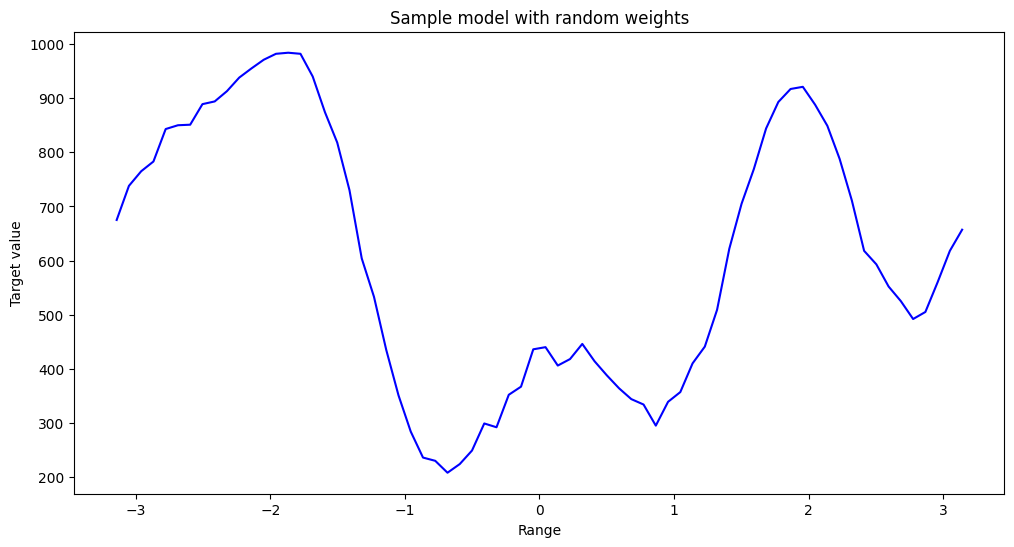

In [87]:


# Define the ansatz function
def serial_fourier_model(layers):
    ansatz = QuantumCircuit(1, 1, name="ansatz")  # One qubit and one classical bit for measurement
    param_x = Parameter('X')
    pno = 0  # Variational parameter counter

    # Data encoding block
    def S():
        ansatz.rx(param_x, 0)

    # Trainable variational block
    def W(layer, label):
        nonlocal pno
        param_w_0 = Parameter(label + '[' + str(pno) + ']')
        param_w_1 = Parameter(label + '[' + str(pno + 1) + ']')
        param_w_2 = Parameter(label + '[' + str(pno + 2) + ']')
        ansatz.u(param_w_0, param_w_1, param_w_2, 0)
        pno += 3

    # Create layers of W, S blocks
    for l in range(layers):
        W(l, 'W')
        S()

    # Add the final block
    W(layers, 'W')


    # Measurement step (measure qubit 0 into classical bit 0)
    ansatz.measure(0, 0)
    return ansatz    

# Define the parameters and data
layers = 5
x_vect = np.linspace(-np.pi, np.pi, 70)
y_vect = []

# Initialize all parameters to random values
param_vals = np.random.random((layers + 1) * 3 + 1) * 2 * np.pi
 # Use the simulator backend
simulator = Aer.get_backend('qasm_simulator')
# Loop over the x values to generate y values (expectation values)
for x in x_vect:
    # Create the circuit using the serial_fourier_model function
    model = serial_fourier_model(layers)
    
    # Update the last parameter value for x
    param_vals[-1] = x
    init_weights = param_vals[:-1]  # Use all parameters except the last one for the model

    # Create a dictionary for the parameters and their corresponding values
    param_dict = {}
    
    # Map the parameter values to their names
    for i, param in enumerate(model.parameters):
        if i < len(init_weights):  # These are the W parameters
            param_dict[param] = init_weights[i]
        else:  # The last parameter is X
            param_dict[param] = x

    # Assign parameters to the model using the dictionary
    model_inst = model.assign_parameters(param_dict)
    
   
    
    # Compile the quantum circuit
    compiled_circuit = transpile(model_inst, simulator)
    
    # Run the simulation (with enough shots)
    sim_result = simulator.run(compiled_circuit, shots=1024).result()  # Increase shots to 1024
    
    # Get the measurement results (counts)
    counts = sim_result.get_counts()

    # Append the result corresponding to the '0' state, handling the case where '0' might not be found
    y_vect.append(counts.get('0', 0))

    # Debugging: print the counts to check if '0' exists
    print(f"Counts for x={x}: {counts}")

# Plot the results
plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Sample model with random weights")
plt.xlabel("Range")
plt.ylabel("Target value")
plt.plot(x_vect, y_vect, color='blue')
plt.show()


In [93]:

def serial_fourier_model(layers):
    
    """ansatz = QuantumCircuit(1, 1, name="ansatz")
    param_x = Parameter('X')
    pno = 0 # Variational parameter counter

    # Data encoding block
    def S():
        ansatz.rx(param_x, 0)

    # Trainable variational block
    def W(layer, label):
        nonlocal pno
        param_w_0 = Parameter(label+'['+str(pno)+']')
        param_w_1 = Parameter(label+'['+str(pno+1)+']')
        param_w_2 = Parameter(label+'['+str(pno+2)+']')
        ansatz.u(param_w_0, param_w_1, param_w_2, 0)
        pno += 3

    # Create layers of W, S blocks
    for l in range(layers):
        W(l, 'W')
        S()

    # Add the final block
    W(layers, 'W')


    # Measurement step (measure qubit 0 into classical bit 0)
    ansatz.measure(0, 0)
    return ansatz    """
    param_x = Parameter("x")
    feature_map = QuantumCircuit(1, name="fm")
    feature_map.ry(param_x, 0)

    # construct simple ansatz
    param_y = Parameter("y")
    ansatz = QuantumCircuit(1, name="vf")
    ansatz.ry(param_y, 0)

    # construct a circuit
    qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)
    return qc


layers = 3 # 9 # 15 # 21 # 27 # 33
qc = serial_fourier_model(layers)
init_weights = 2 * np.pi * np.random.random((layers + 1) * 3 + 1) * 2 * np.pi

"""qc = QNNCircuit(ansatz=model)"""


'qc = QNNCircuit(ansatz=model)'

In [95]:
optimizer = COBYLA(maxiter=100)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

regression_estimator_qnn = EstimatorQNN(circuit=qc)
regressor = NeuralNetworkRegressor(
    neural_network=regression_estimator_qnn,
    loss="squared_error",
    optimizer=L_BFGS_B(maxiter=5),
    callback=callback_graph,
)

print('Regressor with', optimizer.setting.splitlines()[0])
optimizer.settings

Regressor with Optimizer: COBYLA


{'maxiter': 100,
 'disp': False,
 'rhobeg': 1.0,
 'max_evals_grouped': 1,
 'options': {},
 'tol': None}

# Training

In [103]:


# Define X_train and y_train and X_test and y_test via splitting the data
X_train, X_test, y_train, y_test = train_test_split(x_points, y_points, test_size=0.2, random_state=42)
X_train = X_train.reshape(-1, 1)

"""print(X_train, y_train)
print(len(X_train), len(y_train))"""
# Check if the model is constructed correctly
print(model)

# Ensure proper input data shape
print("Input data shapes:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Ensure proper parameters initialization
print("Initial weights:", init_weights)

# Try running the quantum circuit with mock data to see if it works
mock_data = np.random.random((1, 1))
try:
    result = regression_estimator_qnn.forward(mock_data, init_weights)
    print("Mock data result:", result)
except Exception as e:
    print("Error running mock data:", e)

# Run the regressor fit and ensure the objective is progressing
try:
    regressor.fit(X_train, y_train)
except Exception as e:
    print("Error during regressor fitting:", e)

     ┌───────────────────┐┌───────┐┌───────────────────┐┌───────┐»
  q: ┤ U(W[0],W[1],W[2]) ├┤ Rx(X) ├┤ U(W[3],W[4],W[5]) ├┤ Rx(X) ├»
     └───────────────────┘└───────┘└───────────────────┘└───────┘»
c: 1/════════════════════════════════════════════════════════════»
                                                                 »
«     ┌───────────────────┐┌───────┐┌─────────────────────┐┌───────┐»
«  q: ┤ U(W[6],W[7],W[8]) ├┤ Rx(X) ├┤ U(W[9],W[10],W[11]) ├┤ Rx(X) ├»
«     └───────────────────┘└───────┘└─────────────────────┘└───────┘»
«c: 1/══════════════════════════════════════════════════════════════»
«                                                                   »
«     ┌──────────────────────┐┌───────┐┌──────────────────────┐┌─┐
«  q: ┤ U(W[12],W[13],W[14]) ├┤ Rx(X) ├┤ U(W[15],W[16],W[17]) ├┤M├
«     └──────────────────────┘└───────┘└──────────────────────┘└╥┘
«c: 1/══════════════════════════════════════════════════════════╩═
«                                              